In [24]:
import argparse
from collections import defaultdict
import random
from itertools import combinations
import matplotlib.pyplot as plt

import numpy as np
import scipy
from itertools import permutations

In [25]:
class Network:
    """Graph structure for the analysis of the input network
    """

    def __init__(self, file_path):
        """The constructor of the Network class.
        It parses the input file and generates a graph.

        Args:
            file_path (str): The path of the input file
        """
        self.adj = defaultdict(list)
        self.connected = defaultdict(list)

        self.fd = open(file_path, "r", encoding='UTF8')  # File object
        
        for line in self.fd.readlines():
                _line = line.rstrip().split("\t")
                self.connected[int(_line[0])].append(int(_line[1]))
                self.adj[int(_line[0])].append(int(_line[1]))
                self.adj[int(_line[1])].append(int(_line[0]))
                
    def nodes(self):
        return self.adj.keys()
    
    def neighbors(self, x):
        return self.adj[x]
    
    def isConnected(self, x, y):
        if(y in self.connected[x]):
            return True
        else:
            return False

In [26]:
def ESU(G, k):
    k_subgraphs = []
    for v in list(G.nodes()):
        v_extension = set([u for u in G.neighbors(v) if u > v])
        extendSubgraph(G, set([v]), v_extension, v, k, k_subgraphs)
    return k_subgraphs

def extendSubgraph(G, v_subgraph, v_extension, v, k, k_subgraphs):
    if(len(v_subgraph) == k):
        k_subgraphs.append(v_subgraph)
        return
    while (len(v_extension) > 0):
        w = random.choice(tuple(v_extension))
        v_extension.remove(w)
        a = exclusiveNeighborhood(G, w, v_subgraph)
        vpExtension = v_extension | set([u for u in a if u > v])
        extendSubgraph(G, v_subgraph | set([w]), vpExtension, v, k, k_subgraphs)
    return
        
def exclusiveNeighborhood(G, v, Vp):
    Nv = set(G.neighbors(v))
    Nvpll = set([G.neighbors(v) for v in Vp][0])
    return Nv - (Nvpll | set(Vp))

In [27]:
def countMotifs(G, k_subgraphs):
    ######### Task 1. Complete the constructor of Code ##########
    # Given an input graph G and its subgraphs k_subgraphs, count the motifs  
    # return format should be either list or dictionary
    # You may declare any class variable or method if needed
    # E.g., ans[4] should return the number of M_5 in the graph
    #############################################################
    a = list(permutations([1,2,3]))
    motifs = np.array([
        [[0,1,1],
        [0,0,0],
        [0,0,0]],

        [[0,1,0],
        [0,0,1],
        [0,0,0]],

        [[0,1,1],
        [1,0,0],
        [0,0,0]],

        [[0,0,0],
        [1,0,0],
        [1,0,0]],

        [[0,1,1],
        [0,0,1],
        [0,0,0]],

        [[0,1,1],
        [1,0,1],
        [0,0,0]],

        [[0,1,0],
        [1,0,0],
        [1,0,0]],

        [[0,1,1],
        [1,0,0],
        [1,0,0]],

        [[0,1,0],
        [0,0,1],
        [1,0,0]],

        [[0,1,0],
        [1,0,1],
        [1,0,0]],

        [[0,1,0],
        [1,0,0],
        [1,1,0]],

        [[0,1,1],
        [1,0,1],
        [1,0,0]],

        [[0,1,1],
        [1,0,1],
        [1,1,0]]
        ])
        
    ans = [0] * 13

    permute_rowcol = np.zeros((6,3,3), dtype=np.int8)
    for i in range(6):
        for j in range(len(a[i])):
            permute_rowcol[i,j, a[i][j]-1] = 1

    for subgraph_set in k_subgraphs:
        subgraph = list(subgraph_set)
        adj = np.zeros((3,3), dtype=np.int8)

        for i in range(3):
            for j in range(3):
                adj[i][j] = G.isConnected(subgraph[i], subgraph[j])
        
        for i in range(6):
            adj_temp = np.dot(np.dot(permute_rowcol[i], adj), permute_rowcol[i])
            for j in range(13):
                if np.array_equal(adj_temp, motifs[j]):
                    ans[j] += 1
                    break
        
    return ans

In [28]:
# Problem 1: implement the count motif function, which returns the network motif index given an instance corresponding to M_i. 
# Report the absolute counts of each motif M_i (i= 1,···,13) of the given eight graphs.

graph_list = ['email', 'web', 'A', 'B']
graph_motifs = {}

for graph in graph_list:
    # File names of the graphs.
    f_real_graph = './data/' + graph + '.txt'
    f_rand_graph = './data/' + graph + '_random.txt'

    # Generate the graph.
    real_graph = Network(f_real_graph)
    rand_graph = Network(f_rand_graph)

    # Run the ESU algorithm in real graph.
    real_k_subgraphs = ESU(real_graph, 3)
    real_motifs = countMotifs(real_graph, real_k_subgraphs)

    # Run the ESU algorithm in NULL graph.
    rand_k_subgraphs = ESU(rand_graph, 3)
    rand_motifs = countMotifs(rand_graph, rand_k_subgraphs)
    
    # Save the motif counts.
    graph_motifs[graph] = {'real': real_motifs, 'rand': rand_motifs}

In [29]:
def normalizedSignificance(real_motifs, rand_motifs):
     ######### Task 2. Complete the Code ###################################
    # Given an real world graph's motif count and random graph's motif count, return the normalized significance score of each motifs
    # return format should be in list
    # You may declare any class variable or method if needed
    # E.g., ans[4] should return the significance score of M_5 in the graph
    ########################################################################
    real_motifs = np.array(real_motifs)
    rand_motifs = np.array(rand_motifs)

    sig = (real_motifs - rand_motifs) / (real_motifs + rand_motifs + 1)
    norm_sig = list(sig / np.linalg.norm(sig))

    return norm_sig

In [30]:
# Problem 2-1: Compute the normalized significance of each motif.
NS_email = normalizedSignificance(graph_motifs['email']['real'], graph_motifs['email']['rand'])
NS_web = normalizedSignificance(graph_motifs['web']['real'], graph_motifs['web']['rand'])
NS_A = normalizedSignificance(graph_motifs['A']['real'], graph_motifs['A']['rand'])
NS_B = normalizedSignificance(graph_motifs['B']['real'], graph_motifs['B']['rand'])

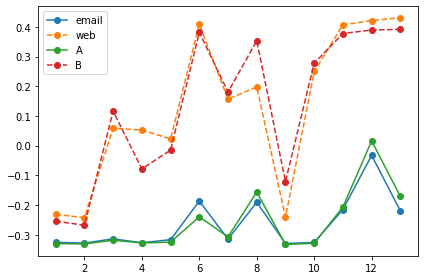

In [31]:
# Problem 2-2: Plot the normalized significance computed above.
plt.plot(list(range(1,14)), NS_email, 'o-', label='email')
plt.plot(list(range(1,14)), NS_web, 'o--', label='web')
plt.plot(list(range(1,14)), NS_A, 'o-', label='A')
plt.plot(list(range(1,14)), NS_B, 'o--', label='B')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Problem 3: One between A and B is a web graph, and the other is an email. What do you think is a web graph? Provide reasons based on the normalized significance obtained in the previous step.
'''
Graphs in the same or similar domain have similar motif significance distribution.
According to the graph above, the distribution of A is similar to email, and B to web.
Therefore, A is an email graph and B is a web graph.
''' 